# Instrumental vs. Vocal Detection in Music with Deep Learning

This tutorial shows how different Convolutional Neural Network architectures are used for the detecting whether a piece of music is instrumental or contains vocals.


The data set used is the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset), but a smaller subset of it, with only 1 sample excerpt of each of the original audio files.

It consists of 5405 files, each 30 seconds long. 

The annotations for this contain a multitude of tags, include some that hint at whether the file is instrumental or vocal. (see [Create 2 classes from a list of tags](#Create-2-classes-from-a-list-of-tags) below)

### Table of Contents

This tutorial contains:
* Loading and Preprocessing of Audio files
* Loading class files from CSV and using Label Encoder
* Audio Preprocessing: Generating log Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks
* Train/Test set split
* ...

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

### Download Data

The (subsampled) data set can be downloaded from [here](https://owncloud.tuwien.ac.at/index.php/s/c2VEkev4YvLgUYu).

Please unzip it.

Set the path to the unpacked folder in the next box:

In [1]:
import os

DATA_PATH = '/home/lidy/temp/MagnaTagATune'
AUDIO_PATH = os.path.join(DATA_PATH, 'audio')
META_PATH = os.path.join(DATA_PATH, 'metadata')

In [2]:
# General Imports

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

# Deep Learning

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization

from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


In [3]:
# local imports for audio reading and processing
import audio_spectrogram as rp
from audiofile_read import audiofile_read

## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [4]:
csv_file = os.path.join(META_PATH,'annotations_final_subsample.csv')

# we select the last column (-1) as the index column (= filename)
metadata = pd.read_csv(csv_file, index_col=-1, sep='\t')
metadata.head(10)

,Unnamed: 0,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
7/aba_structure-epic-01-deep_step-436-465.mp3,0,1211,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-02-luna_dub-59-88.mp3,1,8230,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-03-houseboats-320-349.mp3,2,13259,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3,3,19519,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-05-yelo-262-291.mp3,4,25509,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-06-the_internal-59-88.mp3,5,29611,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-07-erased-0-29.mp3,6,31361,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2/aba_structure-tektonik_illusion-01-terra-320-349.mp3,7,5179,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2/aba_structure-tektonik_illusion-02-illusion-378-407.mp3,8,7790,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# remove the uneeded columns "Unnamed" and "clip_id"
cols = [0,1]
metadata.drop(metadata.columns[cols],axis=1,inplace=True)

metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
7/aba_structure-epic-01-deep_step-436-465.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-02-luna_dub-59-88.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-03-houseboats-320-349.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-05-yelo-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create 2 classes from a list of tags

There are plenty of "tags" in this data set which hint at wether a track is "vocal" or "instrumental". We group these tags and finally come up with 1 boolean column saying whether a track is "vocal" or "instrumental".

In [7]:
tags_vocal = ['singer', 'female singing', 'female opera', 'male vocal', 'vocals', 'men', 'female', 'female voice', 'voice', 'male voice', 'girl', 'chanting', 'talking', 'choral', 'male singer', 'man singing', 'male opera', 'chant', 'man', 'female vocal', 'male vocals', 'vocal', 'woman', 'woman singing', 'singing', 'female vocals', 'voices', 'choir', 'female singer', 'women', 'choir', 'women']

tags_instrumental = ['instrumental', 'no voice', 'no voices', 'no vocals', 'no vocal', 'no singing', 'no singer']

In [8]:
metadata[tags_vocal].head()

,singer,female singing,female opera,male vocal,vocals,men,female,female voice,voice,male voice,...,woman,woman singing,singing,female vocals,voices,choir,female singer,women,choir,women
mp3_path,,,,,,,,,,,,,,,,,,,,,
7/aba_structure-epic-01-deep_step-436-465.mp3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-02-luna_dub-59-88.mp3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-03-houseboats-320-349.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/aba_structure-epic-05-yelo-262-291.mp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# set vocal to True of any of the tags_vocal are 1
gt_vocal = metadata[tags_vocal].any(axis=1)
gt_vocal.head()

mp3_path
7/aba_structure-epic-01-deep_step-436-465.mp3                    True
7/aba_structure-epic-02-luna_dub-59-88.mp3                       True
7/aba_structure-epic-03-houseboats-320-349.mp3                  False
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3    False
7/aba_structure-epic-05-yelo-262-291.mp3                        False
dtype: bool

In [10]:
# set instrumental to True of any of the tags_instrumental are 1
gt_instrumental = metadata[tags_instrumental].any(axis=1)
gt_instrumental.head()

mp3_path
7/aba_structure-epic-01-deep_step-436-465.mp3                   False
7/aba_structure-epic-02-luna_dub-59-88.mp3                      False
7/aba_structure-epic-03-houseboats-320-349.mp3                  False
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3    False
7/aba_structure-epic-05-yelo-262-291.mp3                        False
dtype: bool

<b>We can only use the tag if EITHER instrumental OR vocal is True.</b><br>
If both of them are True or both of them are False, we cannot trust the groundtruth data. Ergo we have to remove these and retain only the others.

In [11]:
retain = np.logical_xor(gt_vocal,gt_instrumental)
retain.head()

mp3_path
7/aba_structure-epic-01-deep_step-436-465.mp3                    True
7/aba_structure-epic-02-luna_dub-59-88.mp3                       True
7/aba_structure-epic-03-houseboats-320-349.mp3                  False
7/aba_structure-epic-04-scrambling_to_stay_ahead-204-233.mp3    False
7/aba_structure-epic-05-yelo-262-291.mp3                        False
dtype: bool

In [12]:
n_orig = len(gt_vocal)

n_retain = sum(retain)

print("From originally", n_orig, "input examples, we can only retain",n_retain, "trusted ones in our groundtruth")

From originally 5405 input examples, we can only retain 1625 trusted ones in our groundtruth


In the end we cut from gt_vocal only the exampls to retain. If they are True they are vocal, if they are False, they are instrumental:

In [13]:
gt_final = gt_vocal[retain]
gt_final.head(9)

mp3_path
7/aba_structure-epic-01-deep_step-436-465.mp3                        True
7/aba_structure-epic-02-luna_dub-59-88.mp3                           True
2/aba_structure-tektonik_illusion-03-pipe-117-146.mp3                True
2/aba_structure-tektonik_illusion-04-im_alive-146-175.mp3            True
b/altri_stromenti-uccellini-01-confitebor_monteverdi-88-117.mp3      True
b/altri_stromenti-uccellini-07-al_sacramento_strozzi-117-146.mp3     True
b/altri_stromenti-uccellini-08-la_ciaccona_uccellini-117-146.mp3    False
b/altri_stromenti-uccellini-10-beatus_uccellini-204-233.mp3          True
1/ambient_teknology-phoenix-02-goa_life-30-59.mp3                   False
dtype: bool

In [14]:
print(sum(gt_final), "vocal tracks")

1186 vocal tracks


In [15]:
print(sum(np.logical_not(gt_final)), "instrumental tracks")

439 instrumental tracks


<b>Create two lists: one with filenames and one with associated classes</b>

In [16]:
# index in list of strings
filelist = gt_final.index.tolist()
# convert boolean to int and store in other list
classes = (gt_final * 1).tolist()

In [17]:
filelist[0:5]

['7/aba_structure-epic-01-deep_step-436-465.mp3',
 '7/aba_structure-epic-02-luna_dub-59-88.mp3',
 '2/aba_structure-tektonik_illusion-03-pipe-117-146.mp3',
 '2/aba_structure-tektonik_illusion-04-im_alive-146-175.mp3',
 'b/altri_stromenti-uccellini-01-confitebor_monteverdi-88-117.mp3']

In [18]:
classes[0:5]

[1, 1, 1, 1, 1]

In [50]:
# converted to Numpy array as needed by Keras
classes = np.array(classes)

## Load the Audio Files

In [19]:
list_spectrograms = [] # spectrograms are put into a list first

# desired output parameters

# orig
#n_mel_bands = 40   # y axis
#frames = 80        # x axis

# enhanced
n_mel_bands = 96   # y axis
frames = 1366        # x axis

# some FFT parameters
fft_window_size=512
fft_overlap = 0.5
hop_size = int(fft_window_size*(1-fft_overlap))
segment_size = fft_window_size + (frames-1) * hop_size # segment size for desired # frames

for filename in filelist:
    print(".", end='')
    filepath = os.path.join(AUDIO_PATH, filename)
    samplerate, samplewidth, wavedata = audiofile_read(filepath,verbose=False)
    sample_length = wavedata.shape[0]

    # make Mono (in case of multiple channels / stereo)
    if wavedata.ndim > 1:
        wavedata = np.mean(wavedata, 1)
        
    # take only a segment; choose start position:
    #pos = 0 # beginning
    pos = int(wavedata.shape[0]/2 - segment_size/2) # center minus half segment size
    wav_segment = wavedata[pos:pos+segment_size]

    # 1) FFT spectrogram 
    spectrogram = rp.calc_spectrogram(wav_segment,fft_window_size,fft_overlap)

    # 2) Transform to perceptual Mel scale (uses librosa.filters.mel)
    spectrogram = rp.transform2mel(spectrogram,samplerate,fft_window_size,n_mel_bands)
        
    # 3) Log 10 transform
    spectrogram = np.log10(spectrogram)
    
    list_spectrograms.append(spectrogram)
        
print("\nRead", len(filelist), "audio files")

........................................................................................................................................................................................................................................................................................................................................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


........................................................................................................................................................................................................................................................................................................................................................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


............................

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Read 1625 audio files


In [20]:
samplerate, samplewidth

(22050, 2)

In [21]:
wav_segment

array([-0.01031494, -0.01708984,  0.00057983, ...,  0.00125122,
       -0.00299072, -0.00738525])

In [22]:
len(list_spectrograms)

1625

In [23]:
spectrogram.shape

(96, 1366)

In [24]:
print("An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long")

An audio segment is 15.87 seconds long


### Show Waveform and Spectrogram

'1/zilla-egg-09-flounder_pile-117-146.mp3'

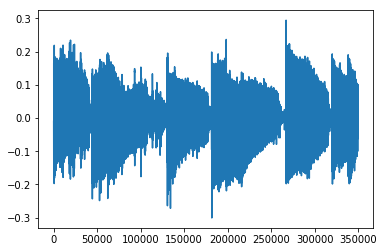

In [25]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

# show 1 sec wave segment
plt.plot(wav_segment)
filename

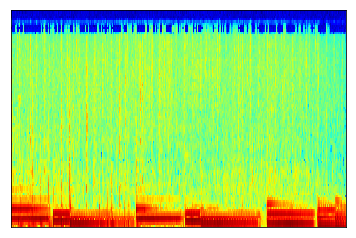

In [27]:
# show spectrogram
fig = plt.imshow(spectrogram, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Make 1 big array of list of spectrograms

In [28]:
# convert the input data to the right data type used by Keras Deep Learning (GPU)
dtype = keras.backend.floatx()
dtype

'float32'

In [30]:
# a list of many spectrograms is made into 1 big array with 3 dimensions
data = np.array(list_spectrograms, dtype=dtype)
data.shape

(1625, 96, 1366)

#### Replace Inf values

As in our preprocessing some files generated an Inf value in the log10 computation, we replace those by 0:

In [35]:
data[np.isinf(data)] = 0

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first.

In [31]:
# vectorize
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(1625, 131136)

In [36]:
# standardize
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [37]:
# show mean and standard deviation: two vectors with same length as data.shape[1]
scaler.mean_, scaler.scale_

(array([ -4.427337 ,  -4.433769 ,  -4.4315267, ..., -11.92735  ,
        -11.950818 , -11.930293 ], dtype=float32),
 array([1.8882886 , 1.8987465 , 1.9110863 , ..., 0.60665023, 0.58325475,
        0.6071809 ], dtype=float32))

# Creating Train & Test Set 

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Here we compare Random Split vs. Stratified Split:

In [ ]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [58]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once, if n_iter==1 resp. n_splits==1

TRAIN INDEX: [1522  737  992 ...  515 1107 1526]
TEST INDEX: [  23 1200  453 1502  958 1371  919  886  192  720  857  466  362 1270
 1254  765  351  142  458  271  123  457  226  717  377  621  152 1247
  522 1091  975 1521  845  374 1496  303 1230  861  868  635  547 1493
  654 1219 1443  991    7 1133  348 1423 1110  878  371 1136 1583  860
 1175   85 1299  604 1301 1027  103 1049 1500 1260 1169 1353 1227 1075
  832  205  558 1235  676 1529 1563  586  332 1393  921 1464 1207 1516
  887  207  370  406  535  569  319  724 1494 1131 1143   29  651  507
  870  684  822  437  560  320 1318  564  508  627  864 1297  477  859
 1525  954  324  249  472 1220 1623  129 1139  294 1010  204 1228 1021
 1549    3 1277 1122  552   54  298  282 1387  258  528 1566  666 1140
  259 1152 1186 1590 1615  118  336   41 1008  183 1183  610  943  229
 1043 1355 1015 1046 1330  148   31  951  672  964 1144 1368  726  977
 1415   49  990 1585  581 1452  662  956 1172  426 1333  875  596 1456
  161 1093  432 

In [56]:
print(train_set.shape)
print(test_set.shape)
# Note: we will reshape the data later back to matrix form 

(1218, 131136)
(407, 131136)


In [57]:
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: 329 Class 1: 889


# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

<i>Note on Tensorflow vs. Theano:</i>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" (for Theano or Tensorflow) *or* with "image_data_format" set to "channels_first" or "channels_last".

Tensorflow is now the default image ordering for Kears ("tf" and/or "channels_last").
To be on the safe side, we added the if statement below.

In [29]:
 keras.backend.image_data_format()

'channels_last'

In [30]:
n_channels = 1 # for grey-scale, 3 for RGB, but usually already present in the data

if keras.backend.image_data_format() == 'channels_last':  # TENSORFLOW
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_set = train_set.reshape(train_set.shape[0], ydim, xdim, n_channels)
    test_set = test_set.reshape(test_set.shape[0], ydim, xdim, n_channels)
else: # THEANO
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_set = train_set.reshape(train_set.shape[0], n_channels, ydim, xdim)
    test_set = test_set.reshape(test_set.shape[0], n_channels, ydim, xdim)

In [31]:
train_set.shape

(96, 40, 80, 1)

In [32]:
test_set.shape

(32, 40, 80, 1)

In [33]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
input_shape = train_set.shape[1:]  
input_shape

(40, 80, 1)

# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

## Creating a Single Layer and a Two Layer CNN

Try: (comment/uncomment code in the following code block)
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [34]:
#np.random.seed(0) # make results repeatable

model = Sequential()

#conv_filters = 16   # number of convolution filters (= CNN depth)
conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Layer 2
model.add(Convolution2D(conv_filters, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 78, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 39, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 18, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
__________

## Training the CNN

In [36]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [37]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 0s 3ms/step - loss: 0.7460 - acc: 0.5104
Epoch 2/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6705 - acc: 0.5312
Epoch 3/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6426 - acc: 0.6354
Epoch 4/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6114 - acc: 0.7188
Epoch 5/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5936 - acc: 0.7188
Epoch 6/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5708 - acc: 0.7188
Epoch 7/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5583 - acc: 0.7396
Epoch 8/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5415 - acc: 0.7396
Epoch 9/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5273 - acc: 0.7604
Epoch 10/15
96/96 [==============================] - 0s 2ms/step - loss: 0.5169 - acc: 0.7604
Epoch 11/15
96/96 [==============================] - 0s 2ms/step - lo

#### Accuracy goes up pretty quickly for 1 layer on Train set! Also on Test set?

### Verifying Accuracy on Test Set

In [38]:
# always execute this, and then a box of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)

In [39]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.71875

In [40]:
# 2 layer
accuracy_score(test_classes, test_pred)

0.71875

In [41]:
# 2 layer + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.71875

In [42]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

0.71875

## Additional Parameters & Techniques

Try out more parameters and techniques: (comment/uncomment code blocks below)
* Adding ReLU activation
* Adding Batch normalization
* Adding Dropout

In [43]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [44]:
# MIREX 2015 model
model = Sequential()

conv_filters = 15   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (12, 8), padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(Activation('sigmoid')) 
model.add(MaxPooling2D(pool_size=(2, 1))) 
#model.add(Dropout(0.3))


# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
#model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [45]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [46]:
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 0s 3ms/step - loss: 0.7729 - acc: 0.4688
Epoch 2/15
96/96 [==============================] - 0s 1ms/step - loss: 0.7734 - acc: 0.4583
Epoch 3/15
96/96 [==============================] - 0s 2ms/step - loss: 0.7648 - acc: 0.5417
Epoch 4/15
96/96 [==============================] - 0s 2ms/step - loss: 0.7545 - acc: 0.4583
Epoch 5/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6950 - acc: 0.5417
Epoch 6/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6950 - acc: 0.5833
Epoch 7/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6554 - acc: 0.5833
Epoch 8/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6468 - acc: 0.6146
Epoch 9/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6807 - acc: 0.6250
Epoch 10/15
96/96 [==============================] - 0s 2ms/step - loss: 0.6628 - acc: 0.6042
Epoch 11/15
96/96 [==============================] - 0s 2ms/step - lo

In [47]:
# Verifying Accuracy on Test Set

test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

0.71875

## Parallel CNNs

It has been discovered, that CNNs for music work best, when they have one filter that is detecting frequencies in the vertical axis, and nother filter that is focused on the time axis, i.e. detecting rhythm. Consequently, this is realized in a parallel CNN, where 2 layers are not stacked after each other, but first run independently in parallel with their output being merged later.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.
In the functional API, you pass the name of the previous layer in (brackets) after defining the next layer.

In [48]:
from keras.layers.merge import concatenate

In [49]:
# Input only specifies the input shape
input = Input(input_shape)

# CNN layers
# specify desired number of filters
n_filters = 16 
# The functional API allows to specify the predecessor in (brackets) after the new Layer function call
conv_layer1 = Convolution2D(16, (10, 2))(input)  # a vertical filter
conv_layer2 = Convolution2D(25, (2, 10))(input)  # a horizontal filter

# possibly add Activation('relu') here

# Pooling layers
maxpool1 = MaxPooling2D(pool_size=(1,2))(conv_layer1) # horizontal pooling
maxpool2 = MaxPooling2D(pool_size=(2,1))(conv_layer2) # vertical pooling

# we have to flatten the Pooling output in order to be concatenated
flat1 = Flatten()(maxpool1)
flat2 = Flatten()(maxpool2)

# Merge the 2
merged = concatenate([flat1, flat2])

full = Dense(256, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(full)

# finally create the model
model = Model(inputs=input, outputs=output_layer)

In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 80, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 31, 79, 16)   336         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 39, 71, 25)   525         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 31, 39, 16)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [51]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [52]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 0s 5ms/step - loss: 0.5242 - acc: 0.7188
Epoch 2/15
96/96 [==============================] - 0s 3ms/step - loss: 0.2932 - acc: 0.8958
Epoch 3/15
96/96 [==============================] - 0s 3ms/step - loss: 0.2043 - acc: 0.9375
Epoch 4/15
96/96 [==============================] - 0s 3ms/step - loss: 0.1615 - acc: 0.9688
Epoch 5/15
96/96 [==============================] - 0s 3ms/step - loss: 0.1361 - acc: 0.9896
Epoch 6/15
96/96 [==============================] - 0s 3ms/step - loss: 0.1095 - acc: 0.9896
Epoch 7/15
96/96 [==============================] - 0s 3ms/step - loss: 0.0953 - acc: 0.9896
Epoch 8/15
96/96 [==============================] - 0s 3ms/step - loss: 0.0815 - acc: 1.0000
Epoch 9/15
96/96 [==============================] - 0s 3ms/step - loss: 0.0726 - acc: 1.0000
Epoch 10/15
96/96 [==============================] - 0s 3ms/step - loss: 0.0641 - acc: 1.0000
Epoch 11/15
96/96 [==============================] - 0s 3ms/step - lo

### Verifying Accuracy on Test Set

Note: The functional API, i.e. Model() does not have a convenience method `.predict_classes()`. We therefore do 'raw' predictions with `predict()`, which returns values between 0 and 1, and then round to the nearest value (0 or 1).

In [53]:
test_pred = model.predict(test_set)
test_pred[0:35,0]

array([1.8116090e-03, 9.9629503e-01, 8.9173570e-02, 1.3832313e-02,
       1.5312824e-02, 6.2414613e-02, 9.4741523e-01, 2.8874350e-01,
       6.6524655e-02, 7.7041835e-01, 5.9007388e-03, 8.8411587e-01,
       7.7622104e-03, 5.5290854e-01, 7.2940448e-03, 9.7821641e-01,
       1.9546174e-03, 1.2710236e-01, 2.5445417e-02, 9.2131579e-01,
       5.5363268e-01, 7.3306054e-02, 9.8920244e-01, 8.6430952e-02,
       8.9812309e-01, 6.6113585e-05, 2.7863439e-03, 9.9372864e-01,
       2.8969401e-02, 9.8893112e-01, 7.3728962e-03, 6.7004067e-01],
      dtype=float32)

In [54]:
test_pred = np.round(test_pred)
accuracy_score(test_classes, test_pred)

0.78125